In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

%matplotlib inline

import redis

cache_ip = '198.13.60.78'
cache_pw = 'da56038fa453c22d2c46e83179126e97d4d272d02ece83eb83a97357e842d065'

r = redis.StrictRedis(host=cache_ip, port=6379, password=cache_pw)

# redis keys
KOSPI_INDEX = 'I.001_INDEX'

KOSPI_TICKERS = 'KOSPI_TICKERS'
KOSDAQ_TICKERS = 'KOSDAQ_TICKERS'

KOSPI_OHLCV = 'KOSPI_OHLCV'
KOSDAQ_OHLCV = 'KOSDAQ_OHLCV'

KOSPI_VOL = 'KOSPI_VOL'
KOSDAQ_VOL = 'KOSDAQ_VOL'

kp_tickers = [ticker.decode() for ticker in r.lrange(KOSPI_TICKERS, 0 ,-1)]
kd_tickers = [ticker.decode() for ticker in r.lrange(KOSDAQ_TICKERS, 0 ,-1)]
tickers = kp_tickers + kd_tickers

In [51]:
# 종가/거래량 데이터 불러오기
kp_ohlcv = pd.read_msgpack(r.get(KOSPI_OHLCV))
kd_ohlcv = pd.read_msgpack(r.get(KOSDAQ_OHLCV))

kp_vol = pd.read_msgpack(r.get(KOSPI_VOL))
kd_vol = pd.read_msgpack(r.get(KOSDAQ_VOL))

# 거래대금 데이터 만들기
kp_vol_prc = kp_ohlcv * kp_vol
kd_vol_prc = kd_ohlcv * kd_vol

# 수익률 데이터 만들기
kp_ret = kp_ohlcv.pct_change()
kd_ret = kd_ohlcv.pct_change()

# 모든 OHLCV, Volume, Return 데이터를 하나로 묶는다
ohlcv = pd.concat([kp_ohlcv, kd_ohlcv], axis=1, sort=True)
volume = pd.concat([kp_vol, kd_vol], axis=1, sort=True)
vol_prc = pd.concat([kp_vol_prc, kd_vol_prc], axis=1, sort=True)
returns = pd.concat([kp_ret, kd_ret], axis=1, sort=True)

### 다수 전략 생성

In [6]:
# 단순 전략 1: 모멘텀 포트폴리오
# 단순 전략 2: 저변동성 포트폴리오
# 단순 전략 3: 수급 포트폴리오

In [52]:
def set_periodic_close(ohlcv_df, period='M'):
    ### 인자 설명:
    ### 1. ohlcv_df (pd.DataFrame)
    ### 2. period (str) --> W, M, Q, 6M, A
    ###                     일주일, 한달, 세달, 여섯달, 일년 주기 종가

    # 인자로 받은 데이터프레임 ohlcv_df의 인덱스를 데이트타임으로 바꿔준다
    ohlcv_df.index = pd.to_datetime(ohlcv_df.index)
    periodic_close = ohlcv_df.resample(
        period).last()  # reference: http://benalexkeen.com/resampling-time-series-data-with-pandas/
    periodic_close.dropna(how='all', inplace=True)
    return periodic_close

In [53]:
def dual_momentum(data):
    # data (pd.DataFrame) --> 한 달을 주기로 resample된 데이터프레임
    # resample 처리가 안 된 상태라면, set_periodic_close() 메소드 사용
    for i in range(1, 13):
        momentum = (data - data.shift(i)) / data.shift(i)  # 단순 수익률: (P(t) - P(t-i))/P(t-i), P = 종가
        if i == 1:
            temp = momentum
        else:
            temp += momentum
    mom = temp / 12  # 위에서 구한 모든 모멘텀값을 더한 후 12로 나눔 (12개월 평균 모멘텀이 된다)
    return mom.fillna(0)  # nan은 0으로 처리

In [54]:
def volatility(returns_data, window=12):
    # 변동성 계산
    # 보통 변동성 계산은 일년을 주기로 계산한다
    # 그래서 returns_data 월별로 resample된거라면 window를 12로 잡는다
    # (데이터가 일일 데이터면 보통 window를 200으로 잡는다)
    # (데이터가 일주일로 resample되었다면, window는 48을 잡는다)
    # (3개월/분기별로 resample 되었다면 window는 4로 잡는다)
    return returns_data.rolling(window=window).std().fillna(0)

In [55]:
# 모멘텀 포트폴리오
ohlcv_m = set_periodic_close(ohlcv)
ret_m = ohlcv_m.pct_change().fillna(0)
momentum = dual_momentum(ohlcv_m)
momentum_rank = momentum.T.rank(ascending=False).T

In [80]:
# 모멘텀 상위 10 종목에 투자
backtest_result = []

for date in range(len(ohlcv_m['2014':]) - 1):
    mom_row = momentum['2014':].iloc[date]
    rank_row = momentum_rank['2014':].iloc[date]
    
    top_rank = rank_row[rank_row < 300].index
    mom_data = mom_row[top_rank]
    abs_mom_index = mom_data[mom_data > 0].index
    
    invest_ret = ret_m['2014':].iloc[date + 1][abs_mom_index].mean()
    backtest_result.append(invest_ret)
    
bt = pd.DataFrame()
bt['Momentum'] = backtest_result

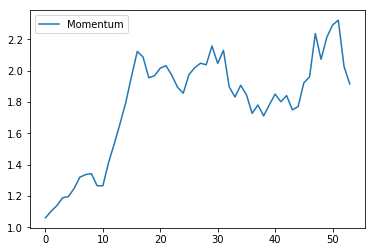

In [81]:
(bt + 1).cumprod().plot()

In [39]:
kp = pd.read_msgpack(r.get(KOSPI_INDEX))
kp_prc = kp['cls_prc']
kp_ret = kp_prc.pct_change().fillna(0)
kp_yc = (kp_ret + 1).cumprod()

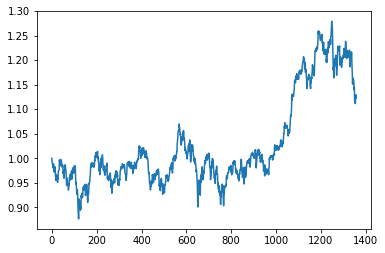

In [40]:
kp_yc.plot()
plt.show()